![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import ast
from collections import Counter
from sklearn import preprocessing
from pprint import pprint



In [2]:
#настроим pandas
pd.set_option('display.max_rows', 25) # выведем больше строк
pd.set_option('display.max_columns', 150) # выведем больше колонок

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Библиотеки (домашние заготовочки)

In [5]:
empty_str_to_none = lambda x: None if type(x) == str and x.strip() == '' else x

str_with_percent_to_float = lambda x: float(x.replace('%', '')) if type(x) == str else x

def show_df_info(df):
    """
    Показать детальную информацию по датасету
    """
    display(df.head())
    print(f"Количество строк в датасете: {df.shape[0]}")
    print(f"Cтолбцы в датасете ({len(df.columns)}):")
    d = pd.DataFrame()
    d['column'] = df.columns
    d['d_type'] = d.apply(lambda x: df[x.column].dtype, axis=1)
    d['not_null_unique_values_count'] = d.apply(lambda x: df[x.column].nunique(), axis=1)
    d['not_null_count'] = d.apply(lambda x: df[x.column].count(), axis=1)
    d['null_count'] = d.apply(lambda x: df[x.column].isnull().sum(), axis=1)
    d['percent_not_null_value'] = d['not_null_count'] / df.shape[0]
    display(d)
    print('Типы столбцов:')
    display(d[['column', 'd_type']].groupby(by='d_type').count().T)
    del d

def show_column_info(df, col, target_col_name = 'Rating', show_hist = True, bins=20, fig_size_x=9, fig_size_y=6):
    '''
    показать детальную инфу по столбцу датасета
    df - датасет
    col - столбец
    '''
    if col in df.columns:
        type_col = df[col].dtype

        print(f"Тип поля {col}: {type_col}")
        print(f"Количество непустых значений: {df[col].count()}  ({round(df[col].count() / len(df), 2) * 100}%)")
        print(f"Количество уникальных непустых значений: {df[col].nunique()}")
        df_count = pd.DataFrame(df[col].value_counts(dropna = False)).sort_values(col).reset_index()
        df_count.columns = [col, 'count']
        df_percent = pd.DataFrame(df[col].value_counts(normalize = True, dropna = False)).sort_values(col).reset_index()
        df_percent.columns = [col, 'percent']
        df_col = df_count.merge(df_percent, on = col, sort=True)

        display(df_col.sort_values(by="count", ascending=False))

        if show_hist:        
            if type_col == 'object':
      
                fig = plt.figure(figsize=(fig_size_x, fig_size_y))
                main_axes = fig.add_axes([0, 0, 1, 1], xlabel=target_col_name, ylabel='count')
                for v in df_col[col]:
                    main_axes.hist(df[((df[col] == v) & (df[target_col_name].notna()))][target_col_name], alpha=0.5, label=v)    
                main_axes.legend()
            elif type_col == 'int64' or type_col == 'float64':
                display(df[col].describe())
                print()
                ax3 = df[col].hist(bins = bins, figsize=(fig_size_x, fig_size_y))
                print()
            else:
                print(f"Неизветсный тип {type_col} столбца {col}")
    else:
        print(f"В датафрейме нет столбца {col}")

def get_boxplot(df, col, col_score, top_values=10):
    """
    Визуализация распределения значений столбца cor_score в зависимости от значений столбца col
    df - датафрейм
    col - столбец с номинативными данными
    col_score - столбец с данными, чьё распределенеи изучается
    top_values - количество наиболее часто встречающихся значений столбца col, которые будут анализироваться
    """
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=col, y=col_score, 
                data=df.loc[df.loc[:, col].isin(df.loc[:, col].value_counts().index[:top_values])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()
        

# DATA

In [6]:
DATA_DIR = '/kaggle/input'

In [7]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/citydata/city_data.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [8]:
df_train = pd.read_csv(DATA_DIR+'/sf-dst-restaurant-rating/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/sf-dst-restaurant-rating/kaggle_task.csv')
df_cities = pd.read_csv(DATA_DIR+'/citydata/city_data.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sf-dst-restaurant-rating/sample_submission.csv')

In [9]:
show_df_info(df_train)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


Количество строк в датасете: 40000
Cтолбцы в датасете (10):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,11909,40000,0,1.000000
1,City,object,31,40000,0,1.000000
2,Cuisine Style,object,9007,30717,9283,0.767925
3,Ranking,float64,11936,40000,0,1.000000
4,Rating,float64,9,40000,0,1.000000
5,Price Range,object,3,26114,13886,0.652850
6,Number of Reviews,float64,1459,37457,2543,0.936425
7,Reviews,object,33516,40000,0,1.000000
8,URL_TA,object,39980,40000,0,1.000000
9,ID_TA,object,39980,40000,0,1.000000


Типы столбцов:


d_type,float64,object
column,3,7


In [10]:
show_df_info(df_test)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


Количество строк в датасете: 10000
Cтолбцы в датасете (9):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,10000,10000,0,1.0000
1,City,object,31,10000,0,1.0000
2,Cuisine Style,object,3128,7693,2307,0.7693
3,Ranking,float64,5914,10000,0,1.0000
4,Price Range,object,3,6525,3475,0.6525
5,Number of Reviews,float64,868,9343,657,0.9343
6,Reviews,object,8358,9998,2,0.9998
7,URL_TA,object,10000,10000,0,1.0000
8,ID_TA,object,10000,10000,0,1.0000


Типы столбцов:


d_type,float64,object
column,2,7


In [11]:
show_df_info(df_cities)

,City,population,area,rests_count
0,Amsterdam,872680,219,3598
1,Athens,664046,39,2239
2,Barcelona,1620343,101,8577
3,Berlin,3769495,891,6005
4,Bratislava,432864,367,1016


Количество строк в датасете: 31
Cтолбцы в датасете (4):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,City,object,31,31,0,1.0
1,population,int64,31,31,0,1.0
2,area,int64,31,31,0,1.0
3,rests_count,int64,31,31,0,1.0


Типы столбцов:


d_type,int64,object
column,3,1


In [12]:
show_df_info(sample_submission)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


Количество строк в датасете: 10000
Cтолбцы в датасете (2):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,10000,10000,0,1.0
1,Rating,float64,9,10000,0,1.0


Типы столбцов:


d_type,float64,object
column,1,1


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

rests = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
show_df_info(rests)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


Количество строк в датасете: 50000
Cтолбцы в датасете (11):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,13094,50000,0,1.00000
1,City,object,31,50000,0,1.00000
2,Cuisine Style,object,10731,38410,11590,0.76820
3,Ranking,float64,12975,50000,0,1.00000
4,Price Range,object,3,32639,17361,0.65278
5,Number of Reviews,float64,1573,46800,3200,0.93600
6,Reviews,object,41857,49998,2,0.99996
7,URL_TA,object,49963,50000,0,1.00000
8,ID_TA,object,49963,50000,0,1.00000
9,sample,int64,2,50000,0,1.00000


Типы столбцов:


d_type,int64,float64,object
column,1,3,7


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Изучим датасет

## Restaurant_id

In [15]:
show_column_info(rests, 'Restaurant_id', show_hist = False)

Тип поля Restaurant_id: object
Количество непустых значений: 50000  (100.0%)
Количество уникальных непустых значений: 13094


,Restaurant_id,count,percent
4507,id_227,19,0.00038
11662,id_871,19,0.00038
6829,id_436,19,0.00038
9018,id_633,19,0.00038
7918,id_534,18,0.00036
...,...,...,...
9142,id_6441,1,0.00002
9141,id_6440,1,0.00002
1735,id_12598,1,0.00002
1736,id_12599,1,0.00002


Похоже, что Restaurant_id явно не укникальный идентификатор ресторана. Можно сделать два предположения:

* Restaurant_id - это некий идентификатор ресторана внутри города
* Restaurant_id - имеет корреляцию с Ranking. 

Проверим эти гипотезы с учетом того, что мы объеденили основную и контрольную выборки

In [16]:
n = len(rests.groupby(['Restaurant_id', 'City', 'sample'])['ID_TA'].count().reset_index()['ID_TA'].loc[lambda x: x>1])
print(f"Неуникальных пар значений Restaurant_id и City: {n}")

Неуникальных пар значений Restaurant_id и City: 0


In [17]:
#корреляция Restaurant_id и Ranking
d = rests[['Restaurant_id', 'Ranking', 'sample']].copy()
d['Restaurant_id'] = d['Restaurant_id'].apply(lambda x: int(x[3:]))
display(d[d['sample']==1][['Restaurant_id', 'Ranking']].corr())
display(d[d['sample']==0][['Restaurant_id', 'Ranking']].corr())

,Restaurant_id,Ranking
Restaurant_id,1.0,1.0
Ranking,1.0,1.0


,Restaurant_id,Ranking
Restaurant_id,1.000000,-0.001706
Ranking,-0.001706,1.000000


Гипотезы подтвердились. Из дальнейшего анализа можно исключить столбец Restaurant_id

## City

Тип поля City: object
Количество непустых значений: 50000  (100.0%)
Количество уникальных непустых значений: 31


,City,count,percent
16,London,7193,0.14386
24,Paris,6108,0.12216
19,Madrid,3813,0.07626
2,Barcelona,3395,0.06790
3,Berlin,2705,0.05410
...,...,...,...
23,Oslo,488,0.00976
12,Helsinki,475,0.00950
4,Bratislava,380,0.00760
17,Luxembourg,263,0.00526


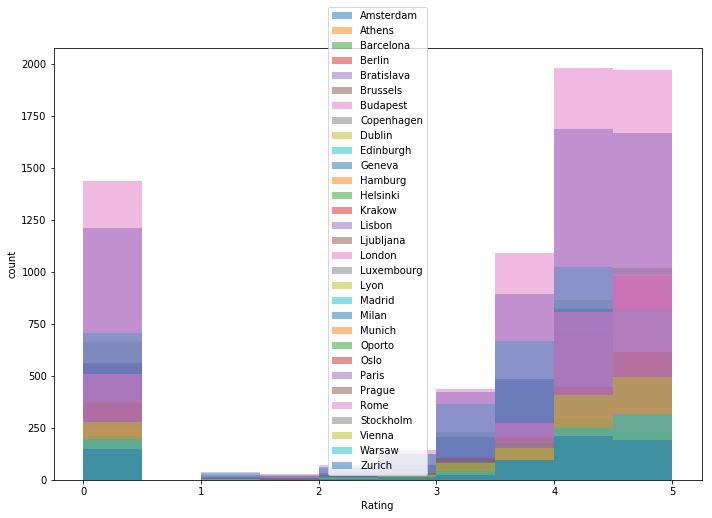

In [18]:
show_column_info(rests, 'City', show_hist = True, bins=10)

In [19]:
# подцепим признаки population, area и rests_count из дополнительного датасета по городам
rests = rests.join(df_cities.set_index('City'), on = 'City', how = 'left')

In [20]:
# плотность населения в городах
rests['density_people'] = rests['population'] / rests['area']
# плотность ресторанов в городах
rests['density_rests'] = rests.rests_count / rests.area
# плотность населения на единицу ресторана
rests['density_people_per_rests'] = rests.population / rests.rests_count
rests.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,population,area,rests_count,density_people,density_rests,density_people_per_rests
39819,id_990,Warsaw,"['Italian', 'Mediterranean', 'Pizza']",991.0,$$ - $$$,16.0,"[['Unexpected good Italian food', 'Excellent p...",/Restaurant_Review-g274856-d753449-Reviews-Tos...,d753449,1,4.5,1790658,517,2674,3463.555126,5.172147,669.655198
4920,id_4920,Barcelona,"['Seafood', 'Mediterranean', 'European', 'Span...",710.0,$$ - $$$,867.0,"[['Bcn at night', 'Market ambience in Barcelon...",/Restaurant_Review-g187497-d3650118-Reviews-Ca...,d3650118,0,0.0,1620343,101,8577,16043.000000,84.920792,188.917220
9530,id_9530,Munich,NaN,2705.0,NaN,4.0,"[['Regular Subway'], ['01/02/2016']]",/Restaurant_Review-g187309-d5507300-Reviews-SU...,d5507300,0,0.0,1471508,310,2831,4746.800000,9.132258,519.783822
20936,id_3359,Vienna,NaN,3361.0,NaN,3.0,"[['akward', 'Good Food!!!!!!!! Local Atmospher...",/Restaurant_Review-g190454-d7593254-Reviews-Ga...,d7593254,1,3.0,1888776,415,3697,4551.267470,8.908434,510.894239
21829,id_862,Rome,"['Italian', 'Mediterranean', 'European', 'Vege...",863.0,$$ - $$$,295.0,"[['Good lunch, good service', 'A reasonably pr...",/Restaurant_Review-g187791-d7390449-Reviews-En...,d7390449,1,4.0,2860009,1285,9921,2225.687938,7.720623,288.278299


In [21]:
#Сохранним dummies-параметры для City в отдельном датасете, так пока будет проще анализировать
city_dummies = rests['City'].str.get_dummies()

city_dummies.sample(5)

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
28736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11353,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36523,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45599,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Ranking

Тип поля Ranking: float64
Количество непустых значений: 50000  (100.0%)
Количество уникальных непустых значений: 12975


,Ranking,count,percent
92,93.0,22,0.00044
490,491.0,21,0.00042
841,842.0,21,0.00042
71,72.0,21,0.00042
1012,1013.0,20,0.00040
...,...,...,...
9420,10267.0,1,0.00002
9418,10265.0,1,0.00002
9417,10264.0,1,0.00002
9415,10260.0,1,0.00002


count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

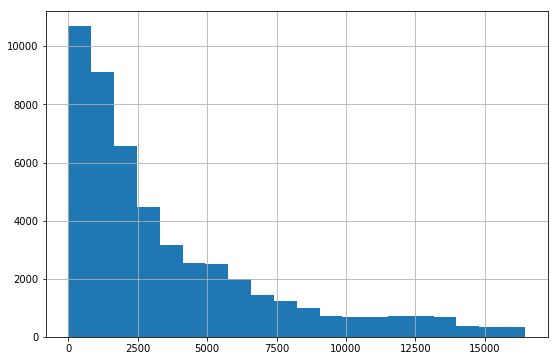

In [22]:
show_column_info(rests, 'Ranking', show_hist = True)

Т.к. Ranking - это рейтинг внутри города, посмотрим как распределены значения внутри городов

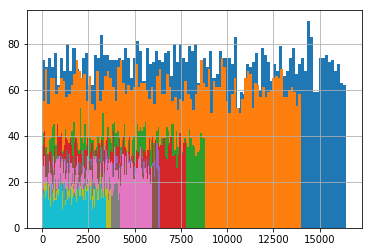

In [23]:
# посмотрим на топ 10 городов
for x in (rests['City'].value_counts())[0:10].index:
    rests['Ranking'][rests['City'] == x].hist(bins=100)
plt.show()

Как видим, абсалютное значение рейтинга зависит от размера города, а скорее от количества ресторанов в городе. Имеет смысл нормалировать значения Ranking внутри городов. Для этого заменим абсалютные значения на отношение к общему числу ресторанов в городе и посмотрим, что изменится.

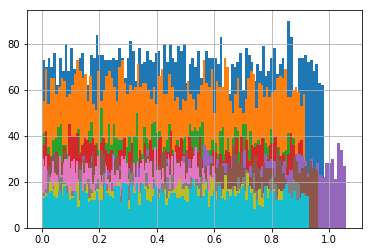

In [24]:
# Нормализация по количеству ресторанов в городе
rests['Ranking_Normalized_by_rests_count'] = rests['Ranking'] / rests['rests_count']

# посмотрим на топ 10 городов
for x in (rests['City'].value_counts())[0:10].index:
    rests['Ranking_Normalized_by_rests_count'][rests['City'] == x].hist(bins=100)
plt.show()

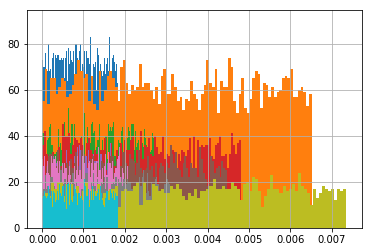

In [25]:
# Посчитаем отношение ranking к population - почему-то это повышает точность
rests['Ranking_Normalized_by_population'] = rests['Ranking'] / rests['population']
# посмотрим на топ 10 городов
for x in (rests['City'].value_counts())[0:10].index:
    rests['Ranking_Normalized_by_population'][rests['City'] == x].hist(bins=100)
plt.show()

## Cuisine Style

In [26]:
show_column_info(rests, 'Cuisine Style', show_hist = False)

Тип поля Cuisine Style: object
Количество непустых значений: 38410  (77.0%)
Количество уникальных непустых значений: 10731


,Cuisine Style,count,percent
10731,NaN,11590,0.23180
7681,['Italian'],1332,0.02664
5225,['French'],1019,0.02038
10125,['Spanish'],860,0.01720
4987,"['French', 'European']",503,0.01006
...,...,...,...
3998,"['European', 'Portuguese', 'Italian', 'Mediter...",1,0.00002
3999,"['European', 'Portuguese', 'Italian', 'Pizza']",1,0.00002
4000,"['European', 'Portuguese', 'Mediterranean', 'C...",1,0.00002
4001,"['European', 'Portuguese', 'Mediterranean', 'C...",1,0.00002


In [27]:
# разберемся с пустыми значениями Cusine Style
rests['Cuisine Style is NAN'] = rests['Cuisine Style'].isna()
rests['Cuisine Style'].fillna("['Usual']", inplace=True)

In [28]:
# Применим библиотеку ast для перевода строковых представлений списков в соответствии с 
# ситнтаксисом языка Python в списки Python
# Подсмотрено в https://www.kaggle.com/alexey300479/top-model
get_list = lambda list_string: ast.literal_eval(list_string)
len_list = lambda list_string: len(ast.literal_eval(list_string))

In [29]:
# Используем sklearn.preprocessing.MultiLabelBinarizer кодирование для признака Cuisine Style
mlb = preprocessing.MultiLabelBinarizer()
cuisines_dummies = pd.DataFrame(mlb.fit_transform(rests['Cuisine Style'].apply(get_list)), columns=mlb.classes_, index=rests.index)

In [30]:
cuisines_dummies

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cajun & Creole,Cambodian,Canadian,Caribbean,Caucasian,Central American,Central Asian,Central European,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,Eastern European,Ecuadorean,Egyptian,Ethiopian,European,Fast Food,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Usual,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
49996,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Гипотеза: привлекательность ресторана может зависеть от количества видов кухней и от того, насколько полно покрывает ресторан виды кухней, представленные в городе

Забегая вперед: данные по количеству видов кухни и производные от них только ухудшали точность предсказания, поэтому не будут использоваться в итоговой модели

In [31]:
# посчитаем количество видов кухней в ресторанах
rests['Cousine count'] = rests['Cuisine Style'].apply(len_list)

# посчитаем количество видов кухней в каждом городе
cities1 = pd.DataFrame()
cities1['City'] = df_cities['City']
cities1['Cousines in City'] = df_cities.apply(lambda row: len(cuisines_dummies[rests['City']==row['City']].sum().to_numpy().nonzero()[0]), axis=1)
rests = rests.join(cities1.set_index('City'), on = 'City', how = 'left')

#посчитаем насколько ресторан покрывает всё разнообразие видов кухней в городе
rests['Cousines coverage'] = rests['Cousine count'] / rests['Cousines in City']

show_df_info(rests)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,population,area,rests_count,density_people,density_rests,density_people_per_rests,Ranking_Normalized_by_rests_count,Ranking_Normalized_by_population,Cuisine Style is NAN,Cousine count,Cousines in City,Cousines coverage
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2148271,105,15242,20459.723810,145.161905,140.944167,0.850479,0.006034,False,2,103,0.019417
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,650058,715,1335,909.172028,1.867133,486.934831,0.079401,0.000163,False,5,72,0.069444
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,512150,102,1706,5021.078431,16.725490,300.205158,0.474795,0.001582,False,1,67,0.014925
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,8908081,607,16740,14675.586491,27.578254,532.143429,0.099701,0.000187,False,5,111,0.045045
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,432864,367,1016,1179.465940,2.768392,426.047244,0.036417,0.000085,False,6,60,0.100000


Количество строк в датасете: 50000
Cтолбцы в датасете (23):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,13094,50000,0,1.00000
1,City,object,31,50000,0,1.00000
2,Cuisine Style,object,10732,50000,0,1.00000
3,Ranking,float64,12975,50000,0,1.00000
4,Price Range,object,3,32639,17361,0.65278
5,Number of Reviews,float64,1573,46800,3200,0.93600
6,Reviews,object,41857,49998,2,0.99996
7,URL_TA,object,49963,50000,0,1.00000
8,ID_TA,object,49963,50000,0,1.00000
9,sample,int64,2,50000,0,1.00000


Типы столбцов:


d_type,bool,int64,float64,object
column,1,6,9,7


## Rating

In [32]:
show_column_info(rests, 'Rating', show_hist = False)

Тип поля Rating: float64
Количество непустых значений: 50000  (100.0%)
Количество уникальных непустых значений: 10


,Rating,count,percent
7,4.0,13692,0.27384
8,4.5,10929,0.21858
0,0.0,10000,0.20000
6,3.5,6824,0.13648
9,5.0,3879,0.07758
5,3.0,2955,0.05910
4,2.5,915,0.01830
3,2.0,466,0.00932
1,1.0,201,0.00402
2,1.5,139,0.00278


Видно, что Rating имеет значения с округлением до 0.5. Вероятно это стоит учесть в дальнейшей работе.

Забегая вперед - округление предсказанного рейтинга с точностью 0.5 оказалось чуть ли не самым значимым способом повышения точности предсказания.

## Price Range

In [33]:
show_column_info(rests, 'Price Range', show_hist = False)
rests['Price Range'].unique()

Тип поля Price Range: object
Количество непустых значений: 32639  (65.0%)
Количество уникальных непустых значений: 3


,Price Range,count,percent
1,$$ - $$$,23041,0.46082
3,NaN,17361,0.34722
0,$,7816,0.15632
2,$$$$,1782,0.03564


array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [34]:
# заменим значения на более удобные для анализа
def t(x):
    if x['Price Range'] == '$':
        return 'Low'
    elif x['Price Range'] == '$$ - $$$':
        return 'Medium'
    elif x['Price Range'] == '$$$$':
        return 'High'
    else:
        return x['Price Range']
rests['Price Range'] = rests.apply(t, axis = 1)    
show_column_info(rests, 'Price Range', show_hist = False)

Тип поля Price Range: object
Количество непустых значений: 32639  (65.0%)
Количество уникальных непустых значений: 3


,Price Range,count,percent
2,Medium,23041,0.46082
3,NaN,17361,0.34722
1,Low,7816,0.15632
0,High,1782,0.03564


Как видно большинство ресторанов в среднем ценовом диапазоне.
Заполним пустые значения также.

In [35]:
# пометим рестораны, у которых не указан ценовой диапазон
rests['Price Range is NAN'] = rests['Price Range'].isna()
rests['Price Range'].fillna('Medium', inplace=True)

Диапазон цен для анализа можно представить как порядковую переменную, так и как dummie-значения
Сформируем наборы данных под оба варианта.

Забегая вперед - более предпочтительным оказался вариант с порядковой переменной.

In [36]:
# Как dummies-параметры
price_range_dummies = rests['Price Range'].str.get_dummies()
show_df_info(price_range_dummies)

,High,Low,Medium
0,0,0,1
1,0,0,1
2,0,0,1
3,1,0,0
4,1,0,0


Количество строк в датасете: 50000
Cтолбцы в датасете (3):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,High,int64,2,50000,0,1.0
1,Low,int64,2,50000,0,1.0
2,Medium,int64,2,50000,0,1.0


Типы столбцов:


d_type,int64
column,3


In [37]:
# Как порядковую переменную
def t(x):
    if x['Price Range'] == 'Low':
        return 1 
    elif x['Price Range'] == 'Medium':
        return 2 
    elif x['Price Range'] == 'High':
        return 3
    else:
        return 0     
price_range_ordinary = pd.DataFrame()    
price_range_ordinary['Price Range Ordinary'] = rests.apply(t, axis = 1)
show_df_info(price_range_ordinary)

,Price Range Ordinary
0,2
1,2
2,2
3,3
4,3


Количество строк в датасете: 50000
Cтолбцы в датасете (1):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Price Range Ordinary,int64,3,50000,0,1.0


Типы столбцов:


d_type,int64
column,1


## Number of Reviews

Тип поля Number of Reviews: float64
Количество непустых значений: 46800  (94.0%)
Количество уникальных непустых значений: 1573


,Number of Reviews,count,percent
1573,NaN,3200,0.06400
0,2.0,2403,0.04806
1,3.0,2042,0.04084
2,4.0,1707,0.03414
3,5.0,1471,0.02942
...,...,...,...
1178,1316.0,1,0.00002
799,810.0,1,0.00002
1175,1312.0,1,0.00002
802,813.0,1,0.00002


count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

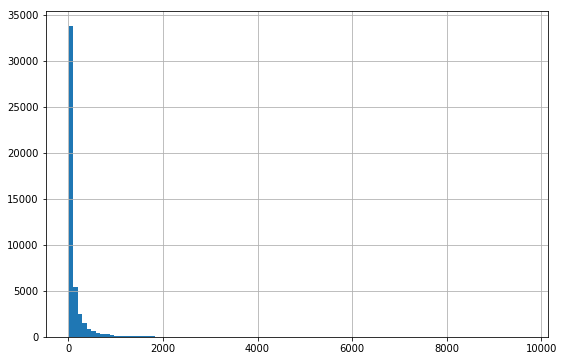

In [38]:
show_column_info(rests, 'Number of Reviews', show_hist = True, bins=100)

In [39]:
# Заполнить пустые значения нулями 
rests['Number of Reviews'].fillna(0, inplace=True)

show_column_info(rests, 'Number of Reviews', show_hist = False)

Тип поля Number of Reviews: float64
Количество непустых значений: 50000  (100.0%)
Количество уникальных непустых значений: 1574


,Number of Reviews,count,percent
0,0.0,3200,0.06400
1,2.0,2403,0.04806
2,3.0,2042,0.04084
3,4.0,1707,0.03414
4,5.0,1471,0.02942
...,...,...,...
1145,1249.0,1,0.00002
1142,1245.0,1,0.00002
1141,1244.0,1,0.00002
1140,1243.0,1,0.00002


In [40]:
# посчтитаем отношение количества отзывов к общему числу отзывов в ресторане
number_of_review_by_cities =rests.groupby(by='City')['Number of Reviews'].sum()
def normalize_number_of_rewies(row, number_of_review_by_cities):
    return row['Number of Reviews'] / number_of_review_by_cities[number_of_review_by_cities.index==row['City']].values[0]
rests['Number of Reviews Normalized'] = rests.apply(lambda row: normalize_number_of_rewies(row, number_of_review_by_cities), axis = 1)
show_df_info(rests)


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,population,area,rests_count,density_people,density_rests,density_people_per_rests,Ranking_Normalized_by_rests_count,Ranking_Normalized_by_population,Cuisine Style is NAN,Cousine count,Cousines in City,Cousines coverage,Price Range is NAN,Number of Reviews Normalized
0,id_0,Paris,"['Bar', 'Pub']",12963.0,Medium,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2148271,105,15242,20459.723810,145.161905,140.944167,0.850479,0.006034,False,2,103,0.019417,False,0.000006
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,Medium,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,650058,715,1335,909.172028,1.867133,486.934831,0.079401,0.000163,False,5,72,0.069444,False,0.003287
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,Medium,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,512150,102,1706,5021.078431,16.725490,300.205158,0.474795,0.001582,False,1,67,0.014925,False,0.000163
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,High,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,8908081,607,16740,14675.586491,27.578254,532.143429,0.099701,0.000187,False,5,111,0.045045,False,0.000216
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,High,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,432864,367,1016,1179.465940,2.768392,426.047244,0.036417,0.000085,False,6,60,0.100000,False,0.009717


Количество строк в датасете: 50000
Cтолбцы в датасете (25):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,13094,50000,0,1.00000
1,City,object,31,50000,0,1.00000
2,Cuisine Style,object,10732,50000,0,1.00000
3,Ranking,float64,12975,50000,0,1.00000
4,Price Range,object,3,50000,0,1.00000
5,Number of Reviews,float64,1574,50000,0,1.00000
6,Reviews,object,41857,49998,2,0.99996
7,URL_TA,object,49963,50000,0,1.00000
8,ID_TA,object,49963,50000,0,1.00000
9,sample,int64,2,50000,0,1.00000


Типы столбцов:


d_type,bool,int64,float64,object
column,2,6,10,7


## Reviews

In [41]:
show_column_info(rests, 'Reviews', show_hist = False)

Тип поля Reviews: object
Количество непустых значений: 49998  (100.0%)
Количество уникальных непустых значений: 41857


,Reviews,count,percent
41855,"[[], []]",8112,0.16224
41857,NaN,2,0.00004
10406,[['Enjoyable restaurant with indoor and outdo....,2,0.00004
17673,"[['Great Asian Option', 'Wow'], ['10/16/2017',...",2,0.00004
14747,"[['Good Paella', 'Good enough. Nothing more'],...",2,0.00004
...,...,...,...
13956,"[['Full on flavour!', 'Eritrean world'], ['12/...",1,0.00002
13957,"[['Full stop', 'Fantastic'], ['01/01/2018', '1...",1,0.00002
13958,"[['Full to the brim!', 'Very good for families...",1,0.00002
13959,"[['Full', 'Cozy place'], ['01/07/2018', '01/06...",1,0.00002


In [42]:
#заполним пустые значения
rests['Reviews'].fillna("[[], []]", inplace=True)

In [43]:
# пометим рестораны, по которым не было отзывов
rests['Reviews is NAN'] = rests['Reviews']=="[[], []]"


In [44]:
import datetime

def date_from_comment(s, y):
    s = s.replace("nan", "None")
    date_list = get_list(s)
    if len(date_list) > 0:
        if len(date_list[1]) > 1:
            return pd.to_datetime(date_list[1][y])
    return datetime.datetime.today()
date_first_comment = lambda s: date_from_comment(s,0)
date_last_comment = lambda s: date_from_comment(s,1)

rests['Date First Comment'] = rests.apply(lambda row: date_first_comment(row['Reviews']), axis=1)
rests['Date Last Comment'] = rests.apply(lambda row: date_last_comment(row['Reviews']), axis=1)

In [45]:
#посчитаем количество дней:
#  * от первого отзыва до Сегодня()
rests['Days from first comment'] = (datetime.datetime.today() - rests['Date First Comment']).dt.days
#  * от последнего отзыва до Сегодня()
rests['Days from last comment'] = (datetime.datetime.today() - rests['Date Last Comment']).dt.days
#  * между отзывами
rests['Days between comments'] = (rests['Date First Comment'] - rests['Date Last Comment']).dt.days
#  * среднее количество отзывов в день. Если 'Days between comments'==0 - то среднее считать 0
rests['Comments per day'] = rests.apply(lambda row: row['Number of Reviews'] / row['Days between comments'] if row['Days between comments'] > 0 else 0, axis=1)


In [46]:
show_df_info(rests)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,population,area,rests_count,density_people,density_rests,density_people_per_rests,Ranking_Normalized_by_rests_count,Ranking_Normalized_by_population,Cuisine Style is NAN,Cousine count,Cousines in City,Cousines coverage,Price Range is NAN,Number of Reviews Normalized,Reviews is NAN,Date First Comment,Date Last Comment,Days from first comment,Days from last comment,Days between comments,Comments per day
0,id_0,Paris,"['Bar', 'Pub']",12963.0,Medium,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2148271,105,15242,20459.723810,145.161905,140.944167,0.850479,0.006034,False,2,103,0.019417,False,0.000006,True,2020-06-15 13:25:04.380035,2020-06-15 13:25:16.728540,0,0,-1,0.000000
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,Medium,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,650058,715,1335,909.172028,1.867133,486.934831,0.079401,0.000163,False,5,72,0.069444,False,0.003287,False,2017-12-05 00:00:00.000000,2017-10-29 00:00:00.000000,923,960,37,2.621622
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,Medium,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,512150,102,1706,5021.078431,16.725490,300.205158,0.474795,0.001582,False,1,67,0.014925,False,0.000163,False,2017-12-28 00:00:00.000000,2017-12-06 00:00:00.000000,900,922,22,1.272727
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,High,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,8908081,607,16740,14675.586491,27.578254,532.143429,0.099701,0.000187,False,5,111,0.045045,False,0.000216,False,2017-12-06 00:00:00.000000,2017-11-22 00:00:00.000000,922,936,14,14.428571
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,High,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,432864,367,1016,1179.465940,2.768392,426.047244,0.036417,0.000085,False,6,60,0.100000,False,0.009717,False,2018-02-08 00:00:00.000000,2018-01-24 00:00:00.000000,858,873,15,10.800000


Количество строк в датасете: 50000
Cтолбцы в датасете (32):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,13094,50000,0,1.0
1,City,object,31,50000,0,1.0
2,Cuisine Style,object,10732,50000,0,1.0
3,Ranking,float64,12975,50000,0,1.0
4,Price Range,object,3,50000,0,1.0
...,...,...,...,...,...,...
27,Date Last Comment,datetime64[ns],15863,50000,0,1.0
28,Days from first comment,int64,1576,50000,0,1.0
29,Days from last comment,int64,2070,50000,0,1.0
30,Days between comments,int64,1650,50000,0,1.0


Типы столбцов:


d_type,bool,int64,float64,datetime64[ns],object
column,3,9,11,2,7


## URL_TA

In [47]:
show_column_info(rests, 'URL_TA', show_hist = False)
rests.loc[1, 'URL_TA']

Тип поля URL_TA: object
Количество непустых значений: 50000  (100.0%)
Количество уникальных непустых значений: 49963


,URL_TA,count,percent
26564,/Restaurant_Review-g187514-d4748208-Reviews-Re...,2,0.00004
25054,/Restaurant_Review-g187514-d11674463-Reviews-B...,2,0.00004
28097,/Restaurant_Review-g187514-d9802625-Reviews-La...,2,0.00004
47637,/Restaurant_Review-g274856-d3396817-Reviews-Re...,2,0.00004
26604,/Restaurant_Review-g187514-d4914988-Reviews-Xi...,2,0.00004
...,...,...,...
16656,/Restaurant_Review-g187309-d2453391-Reviews-Ta...,1,0.00002
16657,/Restaurant_Review-g187309-d2457141-Reviews-Tr...,1,0.00002
16658,/Restaurant_Review-g187309-d2461163-Reviews-Tr...,1,0.00002
16659,/Restaurant_Review-g187309-d2477468-Reviews-Is...,1,0.00002


'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

## ID_TA

In [48]:
show_column_info(rests[rests['sample']==1], 'ID_TA', show_hist = False)
show_column_info(rests[rests['sample']==0], 'ID_TA', show_hist = False)

Тип поля ID_TA: object
Количество непустых значений: 40000  (100.0%)
Количество уникальных непустых значений: 39980


,ID_TA,count,percent
17401,d3161682,2,0.000050
10782,d13002276,2,0.000050
6775,d11999956,2,0.000050
19392,d3685055,2,0.000050
33588,d793170,2,0.000050
...,...,...,...
13331,d1845780,1,0.000025
13332,d1846361,1,0.000025
13333,d1846490,1,0.000025
13334,d1846852,1,0.000025


Тип поля ID_TA: object
Количество непустых значений: 10000  (100.0%)
Количество уникальных непустых значений: 10000


,ID_TA,count,percent
0,d10002758,1,0.0001
6670,d6114834,1,0.0001
6663,d6103998,1,0.0001
6664,d6104186,1,0.0001
6665,d6104211,1,0.0001
...,...,...,...
3333,d1773677,1,0.0001
3334,d1775776,1,0.0001
3335,d1782753,1,0.0001
3336,d1788087,1,0.0001


В обучающей выборке есть неуникальные рестораны. Есть несколько записей, в которых упоминается один и тот же ID_TA
Судя по тому, что остальные параметры одинаковые или очень близци - вероятно это ошибка сбора данных оставим самую свежую запись
Забегая вперед - стало хуже.

In [49]:
rests = rests.drop_duplicates(subset=['ID_TA', 'sample'], keep = 'last')


## И [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

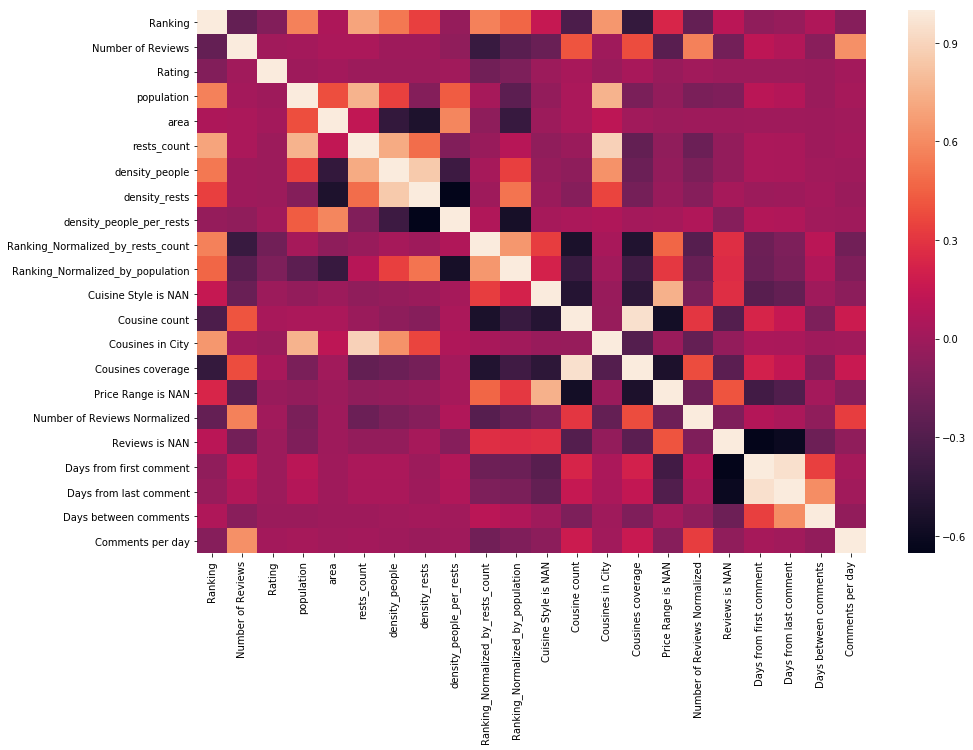

In [50]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(rests.drop(['sample'], axis=1).corr(),)

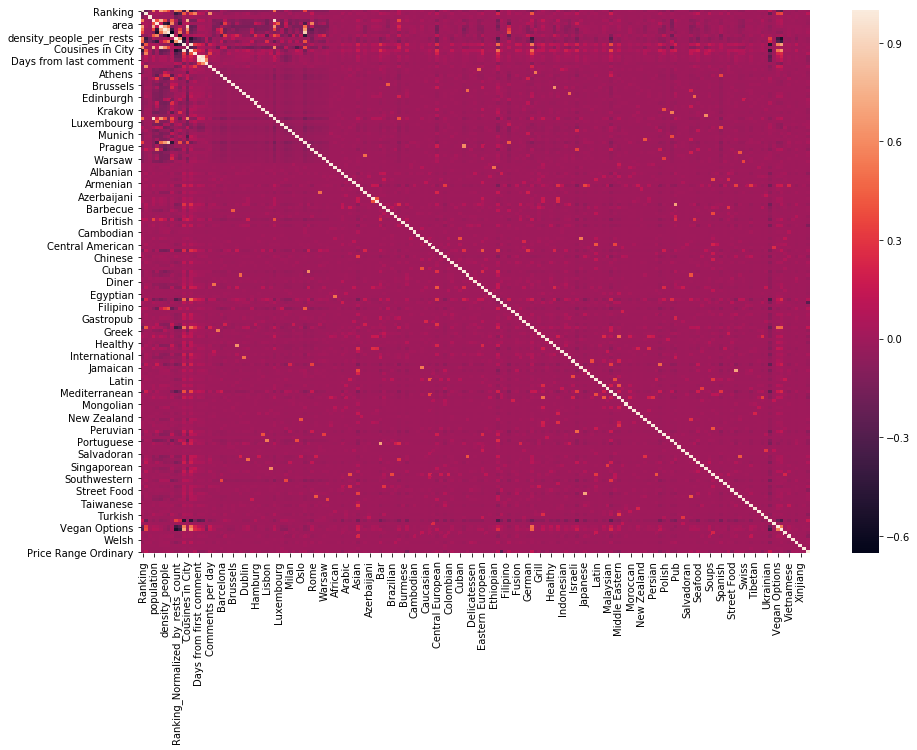

In [51]:
rests1 = pd.concat([rests, city_dummies, cuisines_dummies, price_range_ordinary], axis=1)  
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(rests1.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [52]:
# на всякий случай, заново подгружаем данные

df_train = pd.read_csv(DATA_DIR+'/sf-dst-restaurant-rating/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/sf-dst-restaurant-rating/kaggle_task.csv')
df_cities = pd.read_csv(DATA_DIR+'/citydata/city_data.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sf-dst-restaurant-rating/sample_submission.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
show_df_info(data)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


Количество строк в датасете: 50000
Cтолбцы в датасете (11):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Restaurant_id,object,13094,50000,0,1.00000
1,City,object,31,50000,0,1.00000
2,Cuisine Style,object,10731,38410,11590,0.76820
3,Ranking,float64,12975,50000,0,1.00000
4,Price Range,object,3,32639,17361,0.65278
5,Number of Reviews,float64,1573,46800,3200,0.93600
6,Reviews,object,41857,49998,2,0.99996
7,URL_TA,object,49963,50000,0,1.00000
8,ID_TA,object,49963,50000,0,1.00000
9,sample,int64,2,50000,0,1.00000


Типы столбцов:


d_type,int64,float64,object
column,1,3,7


In [53]:
def preproc_data(df_input, df_cities):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. City ###################################################
    # Добавим параметры по городам из дополнительного датасета
    df_output = df_output.join(df_cities.set_index('City'), on = 'City', how = 'left')
    # посчитаем производные
    df_output['density_people'] = df_output['population'] / df_output['area']
    df_output['density_rests'] = df_output.rests_count / df_output.area
    df_output['density_people_per_rests'] = df_output.population / df_output.rests_count
    #Сохранним dummies-параметры для City в отдельном датасете, так пока будет проще анализировать
    city_dummies = df_output['City'].str.get_dummies()

    # ################### 2. Ranking ###################################################
    df_output['Ranking_Normalized_by_rests_count'] = df_output['Ranking'] / df_output['rests_count']
    df_output['Ranking_Normalized_by_population'] = df_output['Ranking'] / df_output['population']
    #---- df_output.drop(['Ranking'], axis = 1, inplace=True)
    
    # ################### 3. Cuisine Style ###################################################
    df_output['Cuisine Style is NAN'] = df_output['Cuisine Style'].isna()
    df_output['Cuisine Style'].fillna("['Usual']", inplace=True)

    # Используем sklearn.preprocessing.MultiLabelBinarizer кодирование для признака Cuisine Style
    mlb = preprocessing.MultiLabelBinarizer()
    # Применим библиотеку ast для перевода строковых представлений списков в соответствии с 
    # ситнтаксисом языка Python в списки Python
    # Подсмотрено в https://www.kaggle.com/alexey300479/top-model
    get_list = lambda list_string: ast.literal_eval(list_string)
    len_list = lambda list_string: len(ast.literal_eval(list_string))

    cuisines_dummies = pd.DataFrame(mlb.fit_transform(df_output['Cuisine Style'].apply(get_list)), columns=mlb.classes_, index=df_output.index)
    #---- df_output['Cousine count'] = df_output['Cuisine Style'].apply(len_list)


    # ################### 4. Price Range ###################################################
    # заменим значения на более удобные для анализа
    def t(x):
        if x['Price Range'] == '$':
            return 'Low'
        elif x['Price Range'] == '$$ - $$$':
            return 'Medium'
        elif x['Price Range'] == '$$$$':
            return 'High'
        else:
            return x['Price Range']
    df_output['Price Range'] = df_output.apply(t, axis = 1)  

    df_output['Price Range is NAN'] = df_output['Price Range'].isna()
    df_output['Price Range'].fillna('Medium', inplace=True)
    

    # Как dummies-параметры
    #---- price_range_dummies = df_output['Price Range'].str.get_dummies()

    # Как порядковую переменную
    def t(x):
        if x['Price Range'] == 'Low':
            return 1 
        elif x['Price Range'] == 'Medium':
            return 2 
        elif x['Price Range'] == 'High':
            return 3
        else:
            return 0     
    price_range_ordinary = pd.DataFrame()    
    price_range_ordinary['Price Range Ordinary'] = df_output.apply(t, axis = 1)

    
    # ################### 5. Number of Reviews ############################################################## 
    df_output['Number of Reviews is NAN'] = df_output['Number of Reviews'].isna()
    df_output['Number of Reviews'].fillna(0, inplace=True)

    # посчитаем количество отзывов к общему числу отзывов в городе
    number_of_review_by_cities =df_output.groupby(by='City')['Number of Reviews'].sum()
    normalize_number_of_rewies = lambda row, number_of_review_by_cities: row['Number of Reviews'] / \
                                                                         number_of_review_by_cities[number_of_review_by_cities.index==row['City']].values[0]
    df_output['Number of Reviews Normalized'] = df_output.apply(lambda row: normalize_number_of_rewies(row, number_of_review_by_cities), axis = 1)
    
    
    # ################### 6. Reviews ############################################################## 
    #заполним пустые значения
    df_output['Reviews'].fillna("[[], []]", inplace=True)    
    # пометим рестораны, по которым не было отзывов
    df_output['Reviews is NAN'] = df_output['Reviews']=="[[], []]"
    

    def date_from_comment(s, y):
        s = s.replace("nan", "None")
        date_list = get_list(s)
        if len(date_list) > 0:
            if len(date_list[1]) > 1:
                return pd.to_datetime(date_list[1][y])
        return datetime.datetime.today()
    date_first_comment = lambda s: date_from_comment(s,0)
    date_last_comment = lambda s: date_from_comment(s,1)

    df_output['Date First Comment'] = df_output.apply(lambda row: date_first_comment(row['Reviews']), axis=1)
    df_output['Date Last Comment'] = df_output.apply(lambda row: date_last_comment(row['Reviews']), axis=1)
 
    #посчитаем количество дней:
    #  * от первого отзыва до Сегодня()
    df_output['Days from first comment'] = (datetime.datetime.today() - df_output['Date First Comment']).dt.days
    #  * от последнего отзыва до Сегодня()
    df_output['Days from last comment'] = (datetime.datetime.today() - df_output['Date Last Comment']).dt.days
    #  * между отзывами
    df_output['Days between comments'] = (df_output['Date First Comment'] - df_output['Date Last Comment']).dt.days
    #  * среднее количество отзывов в день. Если 'Days between comments'==0 - то среднее считать 0
    #---- df_output['Comments per day'] = df_output.apply(lambda row: row['Number of Reviews'] / row['Days between comments'] if row['Days between comments'] > 0 else 0, axis=1)

    df_output = pd.concat([df_output, city_dummies, cuisines_dummies, price_range_ordinary], axis=1)  

    # ################### 7. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object' or df_output[s].dtypes == 'datetime64[ns]']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [54]:
df_preproc = preproc_data(data, df_cities)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,population,area,rests_count,density_people,density_rests,density_people_per_rests,Ranking_Normalized_by_rests_count,Ranking_Normalized_by_population,Cuisine Style is NAN,Price Range is NAN,Number of Reviews is NAN,Number of Reviews Normalized,Reviews is NAN,Days from first comment,Days from last comment,Days between comments,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cajun & Creole,Cambodian,Canadian,...,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Usual,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,Price Range Ordinary
2937,1098.0,23.0,0,0.0,1324277,496,4559,2669.913306,9.191532,290.475324,0.240842,0.000829,False,False,False,0.000115,False,1404,1498,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
48691,2063.0,10.0,1,3.0,975904,188,2664,5190.978723,14.170213,366.330330,0.774399,0.002114,True,True,False,0.000140,False,978,1070,92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2
8935,3228.0,8.0,0,0.0,1404431,182,6530,7716.653846,35.879121,215.073660,0.494334,0.002298,False,True,False,0.000019,False,1678,1699,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
11369,1702.0,30.0,1,4.0,872680,219,3598,3984.840183,16.429224,242.545859,0.473041,0.001950,False,False,False,0.000155,False,902,933,31,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39037,1446.0,22.0,1,4.5,3223334,604,9991,5336.645695,16.541391,322.623761,0.144730,0.000449,True,True,False,0.000062,False,968,973,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2
29116,1302.0,26.0,1,4.0,872680,219,3598,3984.840183,16.429224,242.545859,0.361868,0.001492,False,False,False,0.000134,False,967,969,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
26846,7143.0,32.0,1,4.0,8908081,607,16740,14675.586491,27.57

In [55]:
show_df_info(df_preproc)

,Ranking,Number of Reviews,sample,Rating,population,area,rests_count,density_people,density_rests,density_people_per_rests,Ranking_Normalized_by_rests_count,Ranking_Normalized_by_population,Cuisine Style is NAN,Price Range is NAN,Number of Reviews is NAN,Number of Reviews Normalized,Reviews is NAN,Days from first comment,Days from last comment,Days between comments,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cajun & Creole,Cambodian,Canadian,...,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Usual,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,Price Range Ordinary
0,12963.0,4.0,0,0.0,2148271,105,15242,20459.723810,145.161905,140.944167,0.850479,0.006034,False,False,False,0.000006,True,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,106.0,97.0,0,0.0,650058,715,1335,909.172028,1.867133,486.934831,0.079401,0.000163,False,False,False,0.003287,False,923,960,37,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2
2,810.0,28.0,0,0.0,512150,102,1706,5021.078431,16.725490,300.205158,0.474795,0.001582,False,False,False,0.000163,False,900,922,22,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
3,1669.0,202.0,0,0.0,8908081,607,16740,14675.586491,27.578254,532.143429,0.099701,0.000187,False,False,False,0.000216,False,922,936,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3
4,37.0,162.0,0,0.0,432864,367,1016,1179.465940,2.768392,426.047244,0.036417,0.000085,False,False,False,0.009717,False,858,873,15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3


Количество строк в датасете: 50000
Cтолбцы в датасете (178):


,column,d_type,not_null_unique_values_count,not_null_count,null_count,percent_not_null_value
0,Ranking,float64,12975,50000,0,1.0
1,Number of Reviews,float64,1574,50000,0,1.0
2,sample,int64,2,50000,0,1.0
3,Rating,float64,10,50000,0,1.0
4,population,int64,31,50000,0,1.0
...,...,...,...,...,...,...
173,Welsh,int64,2,50000,0,1.0
174,Wine Bar,int64,2,50000,0,1.0
175,Xinjiang,int64,2,50000,0,1.0
176,Yunnan,int64,2,50000,0,1.0


Типы столбцов:


d_type,bool,int64,float64
column,4,165,9


In [56]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [57]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [58]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 177), (40000, 177), (40000, 176), (32000, 176), (8000, 176))

# Model 
Сам ML

In [59]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [60]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [61]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [62]:
# Т.к. рейтинг округляется с шагом 0.5, то и предсказания тоже округлим с шагом 0.5
# реализация подстмотрена тут https://www.kaggle.com/alexey300479/top-model
# самый прямой и понятный алгоритм, лучше всё равно не нашлось
def fine_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

# сделаем копию, чтобы иметь возможность сравнить предсказания до и после округления
y_pred_round = y_pred.copy()

# Применим такое округление
for i in range(len(y_pred_round)):
    y_pred_round[i] = fine_rating_pred(y_pred_round[i])


In [63]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE_round:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.20007312500000002
MAE_round: 0.1678125


The best:
MAE: 0.20007312500000002
MAE_round: 0.1678125



Как видим, с округлением точность существенно выше. Дальгше будем использовать округленные предсказания

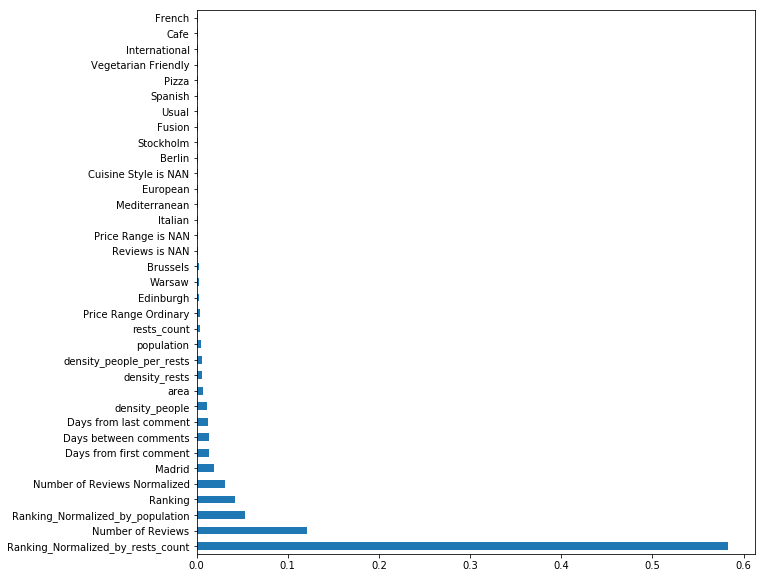

In [64]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(35).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [65]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,population,area,rests_count,density_people,density_rests,density_people_per_rests,Ranking_Normalized_by_rests_count,Ranking_Normalized_by_population,Cuisine Style is NAN,Price Range is NAN,Number of Reviews is NAN,Number of Reviews Normalized,Reviews is NAN,Days from first comment,Days from last comment,Days between comments,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cajun & Creole,Cambodian,Canadian,Caribbean,...,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Usual,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,Price Range Ordinary
8377,4361.0,0.0,0.0,1620343,101,8577,16043.000000,84.920792,188.917220,0.508453,0.002691,False,True,True,0.000000,False,0,0,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4656,2612.0,3.0,0.0,1888776,415,3697,4551.267470,8.908434,510.894239,0.706519,0.001383,True,True,False,0.000028,False,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2
6342,150.0,316.0,0.0,1752286,525,2688,3337.687619,5.120000,651.892113,0.055804,0.000086,False,False,False,0.002130,False,897,901,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2
5052,3389.0,83.0,0.0,8908081,607,16740,14675.586491,27.578254,532.143429,0.202449,0.000380,False,False,False,0.000089,False,901,938,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
9492,1657.0,8.0,0.0,975904,188,2664,5190.978723,14.170213,366.330330,0.621997,0.001698,False,False,False,0.000112,False,1199,1430,231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
7764,4371.0,27.0,0.0,1620343,101,8577,16043.000000,84.920792,188.917220,0.509619,0.002698,False,True,False,0.000063,False,0,0,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3420,1118.0,20.0,0.0,3769495,891,6005,4230.634119,6.739618,627.726062,0

In [66]:
test_data = test_data.drop(['Rating'], axis=1)

In [67]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [68]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [69]:
predict_submission

array([3.105, 4.18 , 4.42 , ..., 3.025, 4.465, 4.215])

In [70]:
# Применим округление
for i in range(len(predict_submission)):
    predict_submission[i] = fine_rating_pred(predict_submission[i])

In [71]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
